In [1]:
import os
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('drive/MyDrive/EAT/')

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

In [4]:
!git clone https://github.com/Rostlab/EAT.git

Cloning into 'EAT'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 173 (delta 91), reused 158 (delta 87), pack-reused 9
Receiving objects: 100% (173/173), 12.91 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [5]:
os.chdir('EAT/')

In [6]:
!wget -P data/ProtTucker/ https://rostlab.org/~deepppi/prottucker_training_embeddings.tar.gz
!tar -xvf data/ProtTucker/prottucker_training_embeddings.tar.gz -C data/ProtTucker/ --strip-components 1
!wget -P data/ProtTucker https://rostlab.org/~deepppi/cath-domain-list.txt

--2022-05-13 06:53:07--  https://rostlab.org/~deepppi/prottucker_training_embeddings.tar.gz
Resolving rostlab.org (rostlab.org)... 131.159.28.73
Connecting to rostlab.org (rostlab.org)|131.159.28.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5897027097 (5.5G) [application/x-gzip]
Saving to: ‘data/ProtTucker/prottucker_training_embeddings.tar.gz’

prottucker_training 100%[===================>]   5.49G  26.3MB/s    in 3m 44s  

2022-05-13 06:56:51 (25.1 MB/s) - ‘data/ProtTucker/prottucker_training_embeddings.tar.gz’ saved [5897027097/5897027097]

embeddings/ESM1b_cath_S100.h5
embeddings/prott5_cath_S100.h5
embeddings/protBERT_bfd_half_cath_S100.h5
embeddings/proseDLM_cathS100.h5
embeddings/proseMT_cathS100.h5
--2022-05-13 07:00:51--  https://rostlab.org/~deepppi/cath-domain-list.txt
Resolving rostlab.org (rostlab.org)... 131.159.28.73
Connecting to rostlab.org (rostlab.org)|131.159.28.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 20 15:37:11 2020

@author: mheinzinger
"""

import seaborn as sn
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable

from pathlib import Path
import time
import random
import copy
import h5py

# The following settings will depend on your setup
# matplotlib import & config
import matplotlib.pyplot as plt
plt.switch_backend('agg')  # GPU is only available via SSH (no display)
plt.clf()  # clear previous figures if already existing

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# https://discuss.pytorch.org/t/reproducibility-with-all-the-bells-and-whistles/81097
def seed_all(seed=42):
    print("[ Using Seed : ", seed, " ]")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return None


class ProtTucker(nn.Module):
    def __init__(self):
        super(ProtTucker, self).__init__()

        self.protTucker = nn.Sequential(
            nn.Linear(1024, 256),  # 512
            nn.Tanh(),
            nn.Linear(256, 128),  # 256
        )

    def single_pass(self, X):
        X = X.float()
        return self.protTucker(X)

    def forward(self, X):
        anchor = self.single_pass(X[:, 0, :])
        pos = self.single_pass(X[:, 1, :])
        neg = self.single_pass(X[:, 2, :])
        return (anchor, pos, neg)
    
    def gen_emb(self, X):
        return self.single_pass(X)


class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, train, datasplitter, n_classes, balanced_sampling=False):
        self.balanced_sampling = balanced_sampling
        self.seq_id, self.embd = zip(
            *[(seq_id, embd) for seq_id, embd in train.items()])

        self.id2label, self.label2id = datasplitter.parse_label_mapping_cath(
            set(train.keys()))

        # if classes should be sampled evenly (not all training samples are used in every epoch)
        if self.balanced_sampling:
            print("Using balanced sampling!")
            self.unique_labels = self.get_unique_labels()
            self.data_len = len(self.unique_labels)
        else:  # if you want to iterate over all training samples
            self.data_len = len(self.seq_id)

        self.id2embedding = train
        self.n_classes = n_classes  # number of class levels

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        if self.balanced_sampling:  # get a CATH class, instead of a trainings sample
            c, a, t, h = self.unique_labels[index] # get CATH class
            anchor_candidates = self.label2id[c][a][t][h] # get samples within this CATH class
            anchor_id = random.choice(anchor_candidates) # randomly pick one of these samples as anchor
            anchor = self.id2embedding[anchor_id] # retrieve embedding for this sample
            anchor_label = self.id2label[anchor_id] # retrieve label for this sample
        else:  # get a training sample (over-samples large CATH families according to occurance)
            anchor = self.embd[index] # get embedding of anchor
            anchor_id = self.seq_id[index] # get CATH ID of anchor
            anchor_label = self.id2label[anchor_id] # get CATH label of anchor
        pos, neg, pos_label, neg_label, pos_sim = self.get_pair(
            anchor_id, anchor_label)
        return (anchor, pos, neg, anchor_label, pos_label, neg_label, pos_sim)

    def get_unique_labels(self):
        unique_set = set()
        unique_labels = list()
        for _, cath_label in self.id2label.items():
            cath_str = '.'.join([str(cath_hierarchy_lvl)
                                for cath_hierarchy_lvl in cath_label])
            if cath_str in unique_set:
                continue
            unique_labels.append(cath_label)
            unique_set.add(cath_str)
        print("Number of unique CATH labels in train: {}".format(len(unique_set)))
        return unique_labels

    def get_rnd_label(self, labels, is_pos, existing_label=None):
        n_labels = len(labels)
        # if alternative labels are available, ensure difference between existing and new label
        if n_labels > 1 and existing_label is not None:
            labels = [label for label in labels if label != existing_label]
            n_labels -= 1

        rnd_idx = np.random.randint(0, n_labels)

        i = iter(labels)
        for _ in range(rnd_idx):
            next(i)
        rnd_label = next(i)
        # do not accidentaly draw the same label; instead draw again if necessary
        if existing_label is not None and rnd_label == existing_label:
            if is_pos:  # return the label itself for positives
                # Allow positives to have the same class as the anchor (relevant for rare classes)
                return existing_label
            else:
                # if there exists no negative sample for a certain combination of anchor and similarity-level
                return None
        return rnd_label

    def get_rnd_candidates(self, anchor_label, similarity_level, is_pos):

        # Get CATH classification of anchor sample
        class_n, arch, topo, homo = anchor_label

        if similarity_level == 0:  # No similarity - different class
            rnd_class = self.get_rnd_label(
                self.label2id.keys(), is_pos, class_n)
            rnd_arch = self.get_rnd_label(
                self.label2id[rnd_class].keys(), is_pos)
            rnd_topo = self.get_rnd_label(
                self.label2id[rnd_class][rnd_arch].keys(), is_pos)
            rnd_homo = self.get_rnd_label(
                self.label2id[rnd_class][rnd_arch][rnd_topo].keys(), is_pos)
            candidates = self.label2id[rnd_class][rnd_arch][rnd_topo][rnd_homo]

        elif similarity_level == 1:  # Same class but different architecture
            rnd_arch = self.get_rnd_label(
                self.label2id[class_n].keys(), is_pos, arch)
            rnd_topo = self.get_rnd_label(
                self.label2id[class_n][rnd_arch].keys(), is_pos)
            rnd_homo = self.get_rnd_label(
                self.label2id[class_n][rnd_arch][rnd_topo].keys(), is_pos)
            candidates = self.label2id[class_n][rnd_arch][rnd_topo][rnd_homo]

        elif similarity_level == 2:  # Same Class & Architecture but different topo
            rnd_topo = self.get_rnd_label(
                self.label2id[class_n][arch].keys(), is_pos, topo)
            rnd_homo = self.get_rnd_label(
                self.label2id[class_n][arch][rnd_topo].keys(), is_pos)
            candidates = self.label2id[class_n][arch][rnd_topo][rnd_homo]

        elif similarity_level == 3:  # Same Class & Architecture & topo but different homo
            rnd_homo = self.get_rnd_label(
                self.label2id[class_n][arch][topo].keys(), is_pos, homo)
            candidates = self.label2id[class_n][arch][topo][rnd_homo]

        # Highest similarity - different homology class (only relevent for positives)
        elif similarity_level == 4:
            candidates = self.label2id[class_n][arch][topo][homo]

        else:
            raise NotImplementedError

        return candidates

    def check_triplet(self, anchor_label, pos_label, neg_label, neg_hardness, pos_hardness):
        assert neg_hardness < pos_hardness, print(
            "Neg sample more similar than pos sample")

        for i in range(0, pos_hardness):
            assert anchor_label[i] == pos_label[i], print("Pos label not overlapping:\n" +
                                                         "Diff: {}\nanchor:{}\npos:{}\nneg:{}".format(pos_hardness, anchor_label, pos_label, neg_label))
        for j in range(0, neg_hardness):
            assert anchor_label[j] == neg_label[j], print("Neg label not overlapping:\n" +
                                                         "Diff: {}\nanchor:{}\npos:{}\nneg:{}".format(neg_hardness, anchor_label, pos_label, neg_label))
        assert anchor_label[neg_hardness] != neg_label[neg_hardness], print(
            "Neg label not different from anchor")
        return None

    def get_pair(self,  anchor_id, anchor_label, hardness_level=None, verbose=False):
        pos, neg = None, None
        pos_label, neg_label = None, None

        while pos is None or neg is None:
            neg_similarity = np.random.randint(self.n_classes)
            pos_similarity = neg_similarity + 1
            try:
                neg_candidates = self.get_rnd_candidates(
                    anchor_label, neg_similarity, is_pos=False) # get set of negative candidates
                neg_id = random.choice(neg_candidates) # randomly pick one of the neg. candidates
                neg_label = self.id2label[neg_id] # get label of randomly picked neg.
                neg = self.id2embedding[neg_id] # get embedding of randomly picked neg.
                
                # repeat the same for the positive sample
                pos_candidates = self.get_rnd_candidates(
                    anchor_label, pos_similarity, is_pos=True)
                pos_id = random.choice(pos_candidates)
                
                # ensure that we do not randomly pick the same protein as anchor and positive
                if pos_id == anchor_id and len(pos_candidates) > 1:
                    while pos_id == anchor_id: # re-draw from the pos. candidates if possible
                        pos_id = random.choice(pos_candidates)
                # if there is only one protein in a superfamily (anchor==positive without other candidates), re-start picking process
                elif pos_id == anchor_id and len(pos_candidates) == 1:
                    continue

                pos = self.id2embedding[pos_id]
                pos_label = self.id2label[pos_id]
                # if we successfully picked anchor, positive and negative candidates, do same sanity checks
                if pos_label is not None and neg_label is not None:
                    self.check_triplet(anchor_label, pos_label,
                                       neg_label, neg_similarity, pos_similarity)
                else: # if no triplet could be formed for a given combination of similarities/classes
                    continue

            except NotImplementedError: #  if you try to create triplets for a class level that is not yet implemented in get_rnd_candidates
                print(anchor_id, anchor_label)
                raise NotImplementedError

            except KeyError:
                # if get_rnd_label returned None because no negative could be found
                # for a certain combination of anchor protein and similarity-lvl
                # re-start picking process
                continue

        if verbose:
            print('#### Example ####')
            print('Anc ({}) label: {}'.format(anchor_id, anchor_label))
            print('Pos ({}) label: {}'.format(pos_id, self.id2label[pos_id]))
            print('Neg ({}) label: {}'.format(neg_id, self.id2label[neg_id]))
            print('#### Example ####')

        return pos, neg, pos_label, neg_label, pos_similarity

    def get_example(self):
        example_id = next(iter(self.id2embedding.keys()))
        example_label = self.id2label[example_id]
        self.get_pair(example_id, example_label, verbose=True)
        return None


class DataSplitter():
    def __init__(self, embedding_p, verbose=True):
        self.verbose = verbose
        self.data_dir = embedding_p.parent
        self.id2embedding = self.get_precomputed_embeddings(embedding_p)

        if verbose:
            print('Loaded embeddings for n_proteins: {}'.format(
                len(self.id2embedding)))

        self.cath_label_path = self.data_dir / 'cath-domain-list.txt'
        self.id2label, self.label2id = self.parse_label_mapping_cath(
                set(self.id2embedding.keys()))

    def get_id2embedding(self):
        return self.id2embedding

    def parse_label_mapping_cath(self, id_subset):
        id2label = dict()
        label2id = dict()
        with open(self.cath_label_path, 'r') as f:
            for n_domains, line in enumerate(f):

                # skip header lines
                if line.startswith("#"):
                    continue

                data = line.split()
                identifier = data[0]
                # skip annotations of proteins without embedding (not part of data set)
                if identifier not in id_subset:
                    continue

                cath_class = int(data[1])
                cath_arch = int(data[2])
                cath_topo = int(data[3])
                cath_homo = int(data[4])

                if cath_class not in label2id:
                    label2id[cath_class] = dict()
                if cath_arch not in label2id[cath_class]:
                    label2id[cath_class][cath_arch] = dict()
                if cath_topo not in label2id[cath_class][cath_arch]:
                    label2id[cath_class][cath_arch][cath_topo] = dict()
                if cath_homo not in label2id[cath_class][cath_arch][cath_topo]:
                    label2id[cath_class][cath_arch][cath_topo][cath_homo] = list()

                id2label[identifier] = [cath_class,
                                        cath_arch, cath_topo, cath_homo]
                label2id[cath_class][cath_arch][cath_topo][cath_homo].append(
                    identifier)

        if self.verbose:
            print('Finished parsing n_domains: {}'.format(n_domains))
            print("Total length of id2label: {}".format(len(id2label)))
        return id2label, label2id

    def read_cath_ids(self, path):
        ids = set()
        id_list = list()
        seq_test = dict()

        with open(path, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    line = line.replace(">", "")
                    if '|' in line:
                        seq_id = line.split('|')[2]
                    else:
                        seq_id = line
                    if seq_id in ids:  # some weird double entries in CATH test set..
                        continue
                    ids.add(seq_id)
                    id_list.append(seq_id)
                    seq_test[seq_id] = list()
                else:
                    seq_test[seq_id].append(line)

        # some identical sequences need to be removed
        seq_set = {''.join(seq): seq_id for seq_id, seq in seq_test.items()}
        id_list = [seq_id for seq, seq_id in seq_set.items()]

        # assert that no identical seqs are in the sets
        assert len(seq_set) == len(id_list)
        if self.verbose:
            print('Example CATH ID: {}'.format(seq_id))
            print('-- Loaded {} proteins from {}'.format(len(id_list), path))
        return id_list

    def get_precomputed_embeddings(self, embedding_p):
        # load pre-computed embeddings in .h5 file format
        h5_f = h5py.File(embedding_p, 'r')
        try:
            dataset = {seq_id.split("|")[2].split("_")[0]: np.expand_dims(np.array(next(iter(embd.items()))[1]), axis=0)
                       for seq_id, embd in h5_f.items()}
        except AttributeError:
            dataset = {seq_id.split("|")[2].split("_")[0]: np.expand_dims(np.array(embd), axis=0)
                       for seq_id, embd in h5_f.items()}

        print("Example: {}".format(next(iter(dataset.keys()))))
        return dataset

    def get_embeddings(self, fasta_path):
        cath_ids = self.read_cath_ids(fasta_path)
        embeddings = dict()
        for cath_id in cath_ids:
            try:
                embd = self.id2embedding[cath_id]
            except KeyError:
                print('No embedding found for: {}'.format(cath_id))
                continue
            embeddings[cath_id] = torch.tensor(embd).to(device)
        return embeddings

    def get_predef_splits(self, p_train=None, p_test=None):

        if p_train is None or p_test is None:
            p_train = self.data_dir / "train66k.fasta"
            p_val = self.data_dir / "val200.fasta"
            p_valLookup20 = self.data_dir / "train66k.fasta"

        val = self.get_embeddings(p_val)
        valLookup20 = self.get_embeddings(p_valLookup20)
        train = self.get_embeddings(p_train)

        if self.verbose:
            print('##########')
            print('Finished splitting data!')
            print('Train set size: {}'.format(len(train)))
            print('Val set size: {}'.format(len(val)))
            print('ValLookup20 size: {}'.format(len(valLookup20)))
            print('##########')
        return train, val, valLookup20


class MyCollator(object):
    def __call__(self, batch):
        X = list()
        Y = list()
        sim = list()
        for (anchor, pos, neg, anchor_label, pos_label, neg_label, pos_sim) in batch:
            x = torch.cat([anchor, pos, neg], dim=0)
            X.append(x.view(1, 3, -1))
            Y.append(self.get_label_vector(anchor_label, pos_label, neg_label))
            sim.append(pos_sim)
        return (torch.cat(X, dim=0), torch.cat(Y, dim=0), torch.tensor(sim))

    def get_label_vector(self, anchor_label, pos_label, neg_label):
        anc = torch.tensor(anchor_label).view(1, -1)
        pos = torch.tensor(pos_label).view(1, -1)
        neg = torch.tensor(neg_label).view(1, -1)
        y = torch.cat([anc, pos, neg], dim=0)
        return y.view(1, 3, -1)


class plotter():
    def __init__(self, log_dir):
        self.init_plotting()
        self.log_dir = log_dir

    def init_plotting(self):
        params = {
            'axes.labelsize': 13,  # increase font size for axis labels
        }
        plt.rc(params)  # apply parameters
        return plt, sn

    def merge_pdfs(self, pdf1_path, pdf2_path, output_path):
        # Merge two PDFs
        from PyPDF2 import PdfFileMerger
        pdfs = [pdf1_path, pdf2_path]

        merger = PdfFileMerger()

        for pdf in pdfs:
            merger.append(pdf)

        merger.write(str(output_path))
        merger.close()
        return None

    def plot_minMaxMean(self, train_minMax, file_name='minMaxMean.pdf'):
        plt, _ = self.init_plotting()

        # Plot first three samples in Batch in one figure
        fig, axes = plt.subplots(1, 1)

        x = np.asarray(train_minMax['min'])
        y = np.asarray(train_minMax['max'])
        z = np.asarray(train_minMax['mean'])
        L = np.arange(1, x.size+1)

        axes.plot(L, x, 'g', label='Min')
        axes.plot(L, y, 'r', label='Max')
        axes.plot(L, z, 'b', label='Mean')

        axes.set_xlabel('Steps/Batches')
        axes.set_ylabel('min/max/mean')

        _ = plt.legend()
        plt.title('Min/Max/Mean development')

        pdf_path = self.log_dir / file_name
        fig.savefig(str(pdf_path), format='pdf')

        plt.close(fig)  # close figure handle
        return None

    def plot_distances(self, dist_pos, dist_neg, file_name='distances.pdf'):
        plt, _ = self.init_plotting()

        # Plot first three samples in Batch in one figure
        fig, axes = plt.subplots(1, 1)

        x = np.asarray(dist_pos)
        y = np.asarray(dist_neg)
        L = np.arange(1, x.size+1)

        axes.plot(L, x, 'g',  label='Dist. Pos')
        axes.plot(L, y, 'r', label='Dist. Neg')

        axes.set_xlabel('Steps/Batches')
        axes.set_ylabel('Distances')

        _ = plt.legend()
        plt.title('Distance development')

        pdf_path = self.log_dir / file_name
        fig.savefig(str(pdf_path), format='pdf')

        plt.close(fig)  # close figure handle
        return None

    def plot_acc(self, acc, baseline, diff_classes=4, file_name='acc.pdf'):

        plt, _ = self.init_plotting()


        fig, axes = plt.subplots(1, 1)

        colors = ['r', 'b', 'g', 'm']
        for diff_class in range(diff_classes):
            x = np.asarray(acc[diff_class])
            max_acc_idx = np.argmax(x)
            max_acc = x[max_acc_idx]
            L = np.arange(1, x.size+1)
            b = np.ones(x.size) * baseline[diff_class]
            axes.plot(L, x, colors[diff_class],  label='LvL.: {} # {:.3f} in epoch {}'.format(
                diff_class, max_acc, max_acc_idx))
            axes.plot(L, b, colors[diff_class]+'-.')

        axes.set_xlabel('Steps/Batches')
        axes.set_ylabel('Accuracy')

        _ = plt.legend()
        plt.title(file_name.replace('.pdf', ''))

        pdf_path = self.log_dir / file_name
        fig.savefig(str(pdf_path), format='pdf')

        plt.close(fig)  # close figure handle
        return None

    def plot_loss(self, train, test=None, file_name='loss.pdf'):
        test = train if test is None else test
        plt, _ = self.init_plotting()
        fig, axes = plt.subplots(1, 1)

        x = np.asarray(train)
        y = np.asarray(test)
        L = np.arange(1, x.size+1)

        axes.plot(L, x, 'g',  label='Train')
        axes.plot(L, y, 'r--', label='Test')

        axes.set_xlabel('Steps/Batches')
        axes.set_ylabel('Loss')

        _ = plt.legend()
        plt.title(file_name.replace('loss.pdf', ''))

        pdf_path = self.log_dir / file_name
        fig.savefig(str(pdf_path), format='pdf')

        plt.close(fig)  # close figure handle
        return None


class Eval():
    def __init__(self, lookup, test, datasplitter, n_classes, name='cath'):
        self.lookup, self.lookupIdx2label = self.preproc(lookup)
        self.test,   self.testIdx2label = self.preproc(test)
        self.id2label, self.label2id = datasplitter.parse_label_mapping_cath(
            # use only keys from the given lookup set
            set(lookup.keys()) | set(test.keys()),
        )
        self.name = name
        #self.log  = self.init_log()
        self.n_classes = n_classes
        self.accs = self.init_log()
        self.errs = self.init_log()
        self.distance = torch.nn.PairwiseDistance(p=2)

    def get_test_set(self):
        return self.test

    def get_lookup_set(self):
        return self.lookup

    def get_acc(self):
        return self.acc

    def get_err(self):
        return self.err

    def init_log(self):
        log = dict()
        for i in range(self.n_classes):
            log[i] = list()
        return log

    def init_confmats(self):
        confmats = list()
        for i in range(self.n_classes):
            confmat = np.zeros((1, 2, 2))
            confmats.append(confmat)
        confmats = np.concatenate(confmats, axis=0)
        return confmats

    def preproc(self, data):
        idx2label = dict()
        dataset = list()
        for idx, (seq_id, embd) in enumerate(data.items()):
            idx2label[idx] = seq_id
            dataset.append(embd)
        dataset = torch.cat(dataset, dim=0)
        return dataset, idx2label

    def add_sample(self, y, yhat, confmats):
        wrong = False

        for class_lvl, true_class in enumerate(y):  # for each prediction
            # skip cases where the test protein did not have had any nn in lookupDB
            # --> It is by defnition not possible that those could be predicted correctly
            if np.isnan(true_class):
                continue
            if not wrong and true_class == yhat[class_lvl]:
                correct = 1  # count only those in
            else:  # if there is a wrong prediction on this level, lower-lvls are wrong by definition
                correct = 0
                wrong = True
            confmats[class_lvl, correct, correct] += 1
        return confmats

    def pdist(self, sample_1, sample_2, norm=2):
        return torch.cdist(sample_1.unsqueeze(dim=0), sample_2.unsqueeze(dim=0), p=norm).squeeze(dim=0)

    def mergeTopK(self, yhats):
        yhats = np.vstack(yhats)

        final_yhat = [None, None, None, None]
        for i in range(self.n_classes):
            (values, counts) = np.unique(yhats[:, i], return_counts=True)
            idxs = np.argmax(counts)
            nn_class = values[idxs]
            final_yhat[i] = nn_class
            mask = yhats[:, i] == nn_class
            yhats = yhats[mask, :]

        return final_yhat

    def mask_singletons(self, y):
        # Mask cases where the only annotated instance is the test protein
        # Those cases can not be predicted correctly without considering self-hits
        c, a, t, h = y
        if len(self.label2id[c][a][t][h]) == 1:  # if h-lvl has only the test prot
            y[-1] = np.nan
            if len(self.label2id[c][a][t]) == 1:  # if t-lvl "
                y[-2] = np.nan
                if len(self.label2id[c][a]) == 1:  # if a-lvl "
                    y[-3] = np.nan
                    if len(self.label2id[c]) == 1:  # if c-lvl "
                        y[-4] = np.nan
        return y

    def compute_err(self, confmat, n_bootstrap=10000):
        n_total = int(confmat.sum())  # total number of predictions
        n_wrong, n_correct = int(confmat[0, 0]), int(confmat[1, 1])
        preds = [0 for _ in range(n_wrong)] + [1 for _ in range(n_correct)]
        subset_accs = list()
        for _ in range(n_bootstrap):
            rnd_subset = random.choices(preds, k=n_total)
            subset_accs.append(sum(rnd_subset)/n_total)
        return np.std(np.array(subset_accs), axis=0, ddof=1)

    def evaluate(self, lookup, queries, n_nearest=1, update=True):
        p_dist = self.pdist(lookup.float(), queries.float())

        _, nn_idxs = torch.topk(p_dist, n_nearest, largest=False, dim=0)

        confmats = self.init_confmats()
        n_test = len(self.testIdx2label)
        for test_idx in range(n_test):  # for all test proteins
            y_id = self.testIdx2label[test_idx]  # get id of test protein
            # get annotation of test (groundtruth)
            y = copy.deepcopy(self.id2label[y_id])
            y = self.mask_singletons(y)

            nn_idx = nn_idxs[:, test_idx]
            yhats = list()
            for nn_i in nn_idx:
                # index of nearest neighbour (nn) in train set
                nn_i = int(toCPU(nn_i))
                # get id of nn (infer annotation)
                yhat_id = self.lookupIdx2label[nn_i]
                # get annotation of nn (groundtruth)
                yhat = self.id2label[yhat_id]
                yhat = np.asarray(yhat)
                yhats.append(yhat)

            if n_nearest == 1:
                assert len(yhats) == 1, print(
                    "More than one NN retrieved, though, n_nearest=1!")
                yhat = yhats[0]
            else:
                yhat = self.mergeTopK(yhats)
            confmats = self.add_sample(y, yhat, confmats)

        if update:  # for constantly monitoring test performance
            for i in range(self.n_classes):
                acc = confmats[i, 1, 1] / confmats[i].sum()
                err = self.compute_err(confmats[i])
                self.accs[i].append(acc)
                self.errs[i].append(err)
            return self.accs, self.errs

        else:  # to get baseline at the beginning
            accs, errs = list(), list()
            # get accuracy per difficulty level
            for i in range(self.n_classes):
                acc = confmats[i, 1, 1] / confmats[i].sum()
                err = self.compute_err(confmats[i])
                accs.append(acc)
                errs.append(err)
                print("Samples for class {}: {}".format(
                    i, sum(confmats[i, :, :])))
            return accs, errs


class TripletLoss(object):
    """Modified from Tong Xiao's open-reid (https://github.com/Cysu/open-reid). 
    Related Triplet Loss theory can be found in paper 'In Defense of the Triplet 
    Loss for Person Re-Identification'."""

    def __init__(self, margin=None, exclude_easy=False, batch_hard=True):
        self.margin = margin
        self.distance = torch.nn.PairwiseDistance(p=2)
        self.exclude_easy = exclude_easy
        self.reduction = 'none' if self.exclude_easy else 'mean'
        self.batch_hard = batch_hard
        self.sample = False
        self.softmax = nn.Softmax(dim=0)
        self.min = -10**10
        if margin is not None:
            self.ranking_loss = nn.MarginRankingLoss(
                margin=margin, reduction=self.reduction)
        else:
            self.ranking_loss = nn.SoftMarginLoss(reduction=self.reduction)

    def __call__(self, anchor, pos, neg, Y, monitor):
        if self.batch_hard:
            dist_ap, dist_an = self.get_batch_hard(anchor, pos, neg, Y)
        else:
            dist_ap = self.distance(anchor, pos)
            dist_an = self.distance(anchor, neg)

        y = Variable(dist_an.data.new().resize_as_(dist_an.data).fill_(1))
        if self.margin is not None:
            loss = self.ranking_loss(dist_an, dist_ap, y)
        else:
            loss = self.ranking_loss(dist_an - dist_ap, y)

        if self.exclude_easy:
            loss = loss.sum() / (loss < 0).sum()

        embeddings = torch.cat((anchor, pos, neg))
        monitor['pos'].append(toCPU(dist_ap.mean()))
        monitor['neg'].append(toCPU(dist_an.mean()))

        monitor['min'].append(toCPU(embeddings.min(dim=1)[0].mean()))
        monitor['max'].append(toCPU(embeddings.max(dim=1)[0].mean()))
        monitor['mean'].append(toCPU(embeddings.mean(dim=1).mean()))

        monitor['loss'].append(toCPU(loss))
        monitor['norm'].append(toCPU(torch.norm(embeddings, p='fro')))

        return loss

    # https://gist.github.com/rwightman/fff86a015efddcba8b3c8008167ea705
    def get_hard_triplets(self, pdist, y, prev_mask_pos):
        n = y.size()[0]
        mask_pos = y.expand(n, n).eq(y.expand(n, n).t()).to(device)

        mask_pos = mask_pos if prev_mask_pos is None else prev_mask_pos * mask_pos

        # every protein that is not a positive is automatically a negative for this lvl
        mask_neg = ~mask_pos
        mask_pos[torch.eye(n).bool().cuda()] = 0  # mask self-interactions
        mask_neg[torch.eye(n).bool().cuda()] = 0

        if self.sample:
            # weighted sample pos and negative to avoid outliers causing collapse
            posw = (pdist + 1e-12) * mask_pos.float()
            posw[posw == 0] = self.min
            posw = self.softmax(posw)
            posi = torch.multinomial(posw, 1)

            dist_ap = pdist.gather(0, posi.view(1, -1))
            # There is likely a much better way of sampling negatives in proportion their difficulty, based on distance
            # this was a quick hack that ended up working better for some datasets than hard negative
            negw = (1 / (pdist + 1e-12)) * mask_neg.float()
            negw[posw == 0] = self.min
            negw = self.softmax(posw)
            negi = torch.multinomial(negw, 1)
            dist_an = pdist.gather(0, negi.view(1, -1))
        else:
            ninf = torch.ones_like(pdist) * float('-inf')
            dist_ap = torch.max(pdist * mask_pos.float(), dim=1)[0]
            nindex = torch.max(torch.where(mask_neg, -pdist, ninf), dim=1)[1]
            dist_an = pdist.gather(0, nindex.unsqueeze(0)).view(-1)

        return dist_ap, dist_an, mask_pos

    def get_batch_hard(self, anchor, pos, neg, Y):
        Y = torch.cat([Y[:, 0, :], Y[:, 1, :], Y[:, 2, :]], dim=0)
        X = torch.cat([anchor, pos, neg], dim=0)
        pdist = self.pdist(X)

        dist_ap, dist_an = list(), list()
        mask_pos = None

        for i in range(4):
            y = Y[:, i]
            dist_pos, dist_neg, mask_pos = self.get_hard_triplets(
                pdist, y, mask_pos)
            dist_ap.append(dist_pos.view(-1))
            dist_an.append(dist_neg.view(-1))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        return dist_ap, dist_an

    def pdist(self, v):
        dist = torch.norm(v[:, None] - v, dim=2, p=2)
        return dist


class Saver():
    def __init__(self, experiment_dir):
        self.experiment_dir = experiment_dir
        self.checkpoint_p = experiment_dir / 'checkpoint.pt'
        self.best_performance = 0
        self.num_classes = 4
        self.epsilon = 1e-3

    def load_checkpoint(self):
        state = torch.load(self.checkpoint_p)
        model = ProtTucker().to(device)
        model.load_state_dict(state['state_dict'])
        print('Loaded model from epch: {:.1f} with avg. acc: {:.3f}'.format(
            state['epoch'], self.best_avg_acc))
        return model, state['epoch']

    def save_checkpoint(self, model, epoch, optimizer):
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, self.checkpoint_p)
        return None

    def check_performance(self, acc, model, epoch, optimizer):
        if isinstance(acc, dict):  # if a list of accuracies is passed
            new_performance = acc[3][-1]
        else:  # if a single Silhouette score is passed
            new_performance = acc
        if new_performance > self.best_performance + self.epsilon:
            self.save_checkpoint(model, epoch, optimizer)
            self.best_performance = new_performance
            print('New best performance found:  {:.3f}!'.format(
                self.best_performance))
            return self.best_performance
        return None


def init_monitor():
    monitor = dict()

    monitor['loss'] = list()
    monitor['norm'] = list()

    monitor['pos'] = list()
    monitor['neg'] = list()

    monitor['min'] = list()
    monitor['max'] = list()
    monitor['mean'] = list()
    return monitor


# move torch/GPU tensor to numpy/CPU
def toCPU(data):
    return data.cpu().detach().numpy()


# count number of free parameters in the network
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Create dataloaders with custom collate function
def dataloader(customdata, batch_size):
    my_collator = MyCollator()
    return torch.utils.data.DataLoader(dataset=customdata,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       drop_last=True,
                                       collate_fn=my_collator,
                                       )



# get baseline performance (no ProtTucker but raw pLM embeddings)
def get_baseline(test):
    test_set = test.get_test_set()
    train_set = test.get_lookup_set()
    acc, err = test.evaluate(train_set, test_set, update=False)
    print(('BASELINE\nACC-C: {:.2f} +/- {:.2f}\nACC-A: {:.2f} +/- {:.2f}\n' +
           'ACC-T: {:.2f} +/- {:.2f}\nACC-H: {:.2f} +/- {:.2f}\nAvg. Acc: {:.2f} +/- {:.2f}').format(
        acc[0], err[0], acc[1], err[1], acc[2], err[2], acc[3], err[3],
        (acc[0] + acc[1] + acc[2] + acc[3]) /
        4, (err[0] + err[1] + err[2] + err[3])/4,
    ))
    return acc, err



# test performance during training on validation set (used also for early stopping)
def testing(model, test):
    model.eval()
    with torch.no_grad():  # evaluate current performance (no grads)
        test_emb = test.get_test_set()
        lookup_emb = test.get_lookup_set()
        test_tucker = model.single_pass(test_emb)
        lookup_tucker = model.single_pass(lookup_emb)
        acc, err = test.evaluate(lookup_tucker, test_tucker)
    model.train()
    return acc, err




# Original Loss

In [7]:
# measure training time
start_overall = time.time()
# set random seeds
SEED = 42
seed_all(SEED)
# set up directory structure
root = Path.cwd()
data_dir = root / 'data' # create a directory for logging your experiments
log_dir = root / 'log' / 'your_log_directory'
embedding_p = data_dir / "ProtTucker" /"prott5_cath_S100.h5" # path to your pre-computed embeddings. IDs have to align with label IDs
print("Loading dataset from: {}".format(embedding_p))
# give your experiment a meaningful name here
experiment_name = "your_experiment"
experiment_dir = log_dir / experiment_name
if not experiment_dir.is_dir():
    print("Creating new log-directory: {}".format(experiment_dir))
    experiment_dir.mkdir(parents=True)
# Hyperparameters
learning_rate = 1e-3
batch_size = 256 # the number of actual samples per batch might be higher due to batch-hard sampling (see paper for more details)
num_epochs = 200  # will stop earlier if early stopping is triggered
n_classes = 4  # number of class-lvls; makes it easier to adjust for other problems
n_bad = 0 # counter for number of epochs that did not improve (counter for early stopping)
n_thresh = 20  # threshold for number of epochs that did not improve (threshold for early stopping)
batch_hard = True  # whether to activate batch_hard sampling (recommneded)
exclude_easy = False # whether to exclude trivial samples (did not improve performa)
margin = None # set this to a float to activate threshold-dependent loss functions (see TripletLoss)
# initialize plotting class (used to monitor loss etc during training)
pltr = plotter(experiment_dir)
# Prepare datasets
datasplitter = DataSplitter(embedding_p)
train_splits, val, val_lookup20 = datasplitter.get_predef_splits()
val20 = Eval(val_lookup20, val,  datasplitter, n_classes)
train = CustomDataset(train_splits, datasplitter, n_classes)
train.get_example()
train.get_example()
train.get_example()
train = dataloader(train, batch_size)
model = ProtTucker().to(device)
criterion = TripletLoss(exclude_easy=exclude_easy,
                        batch_hard=batch_hard, margin=margin)
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, amsgrad=True)
saver = Saver(experiment_dir)
saver.save_checkpoint(model, 0, optimizer)
baseline_acc, baseline_err = get_baseline(val20)
print('###### Training parameters ######')
print('Experiment name: {}'.format(experiment_name))
print('LR: {}, BS: {}, free Paras.: {}, n_epochs: {}'.format(
    learning_rate, batch_size, count_parameters(model), num_epochs))
print('#############################\n')
print('Start training now!')
monitor = init_monitor()
for epoch in range(num_epochs):  # for each epoch
    # =================== testing =====================
    start = time.time()
    acc, err = testing(model, val20)  # evaluate using the validation
    test_time = time.time() - start
    new_best = saver.check_performance(
        acc, model, epoch, optimizer)  # early stopping class
    if new_best is None:  # if the new accuracy was worse than a previous one
        n_bad += 1
        if n_bad >= n_thresh:  # if more than n_bad consecutive epochs were worse, break training
            break
    else:  # if the new accuracy is larger than the previous best one by epsilon, reset counter
        n_bad = 0
    # =================== training =====================
    # monitor epoch-wise performance
    epoch_monitor = init_monitor()
    start = time.time()
    for train_idx, (X, Y, _) in enumerate(train):  # for each batch in the training set
        X = X.to(device)
        Y = Y.to(device)
        anchor, pos, neg = model(X)
        loss = criterion(anchor, pos, neg, Y, epoch_monitor)
        # =================== backward ====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time = time.time() - start
       # monitor various metrics during training
    monitor['loss'].append(
        sum(epoch_monitor['loss']) / len(epoch_monitor['loss']))
    monitor['norm'].append(
        sum(epoch_monitor['norm']) / len(epoch_monitor['norm']))
    monitor['pos'].append(sum(epoch_monitor['pos']) /
                          len(epoch_monitor['pos']))
    monitor['neg'].append(sum(epoch_monitor['neg']) /
                          len(epoch_monitor['neg']))
    monitor['min'].append(sum(epoch_monitor['min']) /
                          len(epoch_monitor['min']))
    monitor['max'].append(sum(epoch_monitor['max']) /
                          len(epoch_monitor['max']))
    monitor['mean'].append(
        sum(epoch_monitor['mean']) / len(epoch_monitor['mean']))
    train_time = time.time() - start
    # ===================log========================
    if epoch % 5 == 0 or epoch == num_epochs-1:  # draw plots only every fifth epoch
        pltr.plot_acc(acc, baseline_acc)
        pltr.plot_distances(monitor['pos'], monitor['neg'])
        pltr.plot_loss(monitor['loss'], file_name='loss.pdf')
        pltr.plot_loss(monitor['norm'], file_name='norm.pdf')
        pltr.plot_minMaxMean(monitor)
    # Always print training progress to console
    print(('epoch [{}/{}], train loss: {:.3f}, train-time: {:.1f}[s], test-time: {:.1f}[s], ' +
          'ACC-C: {:.2f}, ACC-A: {:.2f}, ACC-T: {:.2f}, ACC-H: {:.2f} ## Avg. Acc: {:.2f}').format(
        epoch + 1, num_epochs,
        monitor['loss'][-1],
        train_time, test_time,
        acc[0][-1], acc[1][-1], acc[2][-1], acc[3][-1],
        (acc[0][-1] + acc[1][-1] + acc[2][-1] + acc[3][-1])/4
    ))
end_overall = time.time()
print(end_overall-start_overall)
print("Total training time: {:.1f}[m]".format(
    (end_overall-start_overall)/60))


[ Using Seed :  42  ]
Loading dataset from: /content/drive/MyDrive/EAT/EAT/data/ProtTucker/prott5_cath_S100.h5
Example: 107lA00
Loaded embeddings for n_proteins: 122727
Finished parsing n_domains: 500253
Total length of id2label: 122727
Example CATH ID: 2anlA01
-- Loaded 200 proteins from /content/drive/MyDrive/EAT/EAT/data/ProtTucker/val200.fasta
Example CATH ID: 9wgaA04
-- Loaded 66052 proteins from /content/drive/MyDrive/EAT/EAT/data/ProtTucker/train66k.fasta
Example CATH ID: 9wgaA04
-- Loaded 66052 proteins from /content/drive/MyDrive/EAT/EAT/data/ProtTucker/train66k.fasta
##########
Finished splitting data!
Train set size: 66052
Val set size: 200
ValLookup20 size: 66052
##########
Finished parsing n_domains: 500253
Total length of id2label: 66252
Finished parsing n_domains: 500253
Total length of id2label: 66052
#### Example ####
Anc (4qkrA00) label: [2, 80, 10, 50]
Pos (4mzgB00) label: [2, 80, 10, 70]
Neg (1yu0A02) label: [2, 80, 20, 10]
#### Example ####
#### Example ####
Anc (4

In [107]:
xtsne = []
ytsne = []
for i in list(train.id2embedding.keys()):
  if train.id2label[i][0] <= 4:
    xtsne.append(train.id2embedding[i].detach().cpu().numpy())
    ytsne.append(train.id2label[i][0])

In [109]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.array(xtsne).squeeze(1))

In [111]:
cdict = {1: 'crimson', 2: 'steelblue', 3: 'limegreen', 4: 'mediumorchid'}

fig, ax = plt.subplots()
for g in np.unique(np.array(ytsne)):
    ix = np.where(np.array(ytsne) == g)
    ax.scatter(X_embedded[:,0][ix], X_embedded[:,1][ix], c = cdict[g], label = g, s = 100)
ax.legend(["Mainly Alpha", "Mainly Beta", "Alpha Beta", "Few SS"], fontsize=30, title_fontsize=35,loc='best')
plt.savefig("orignal_embeddings.png")
plt.show()

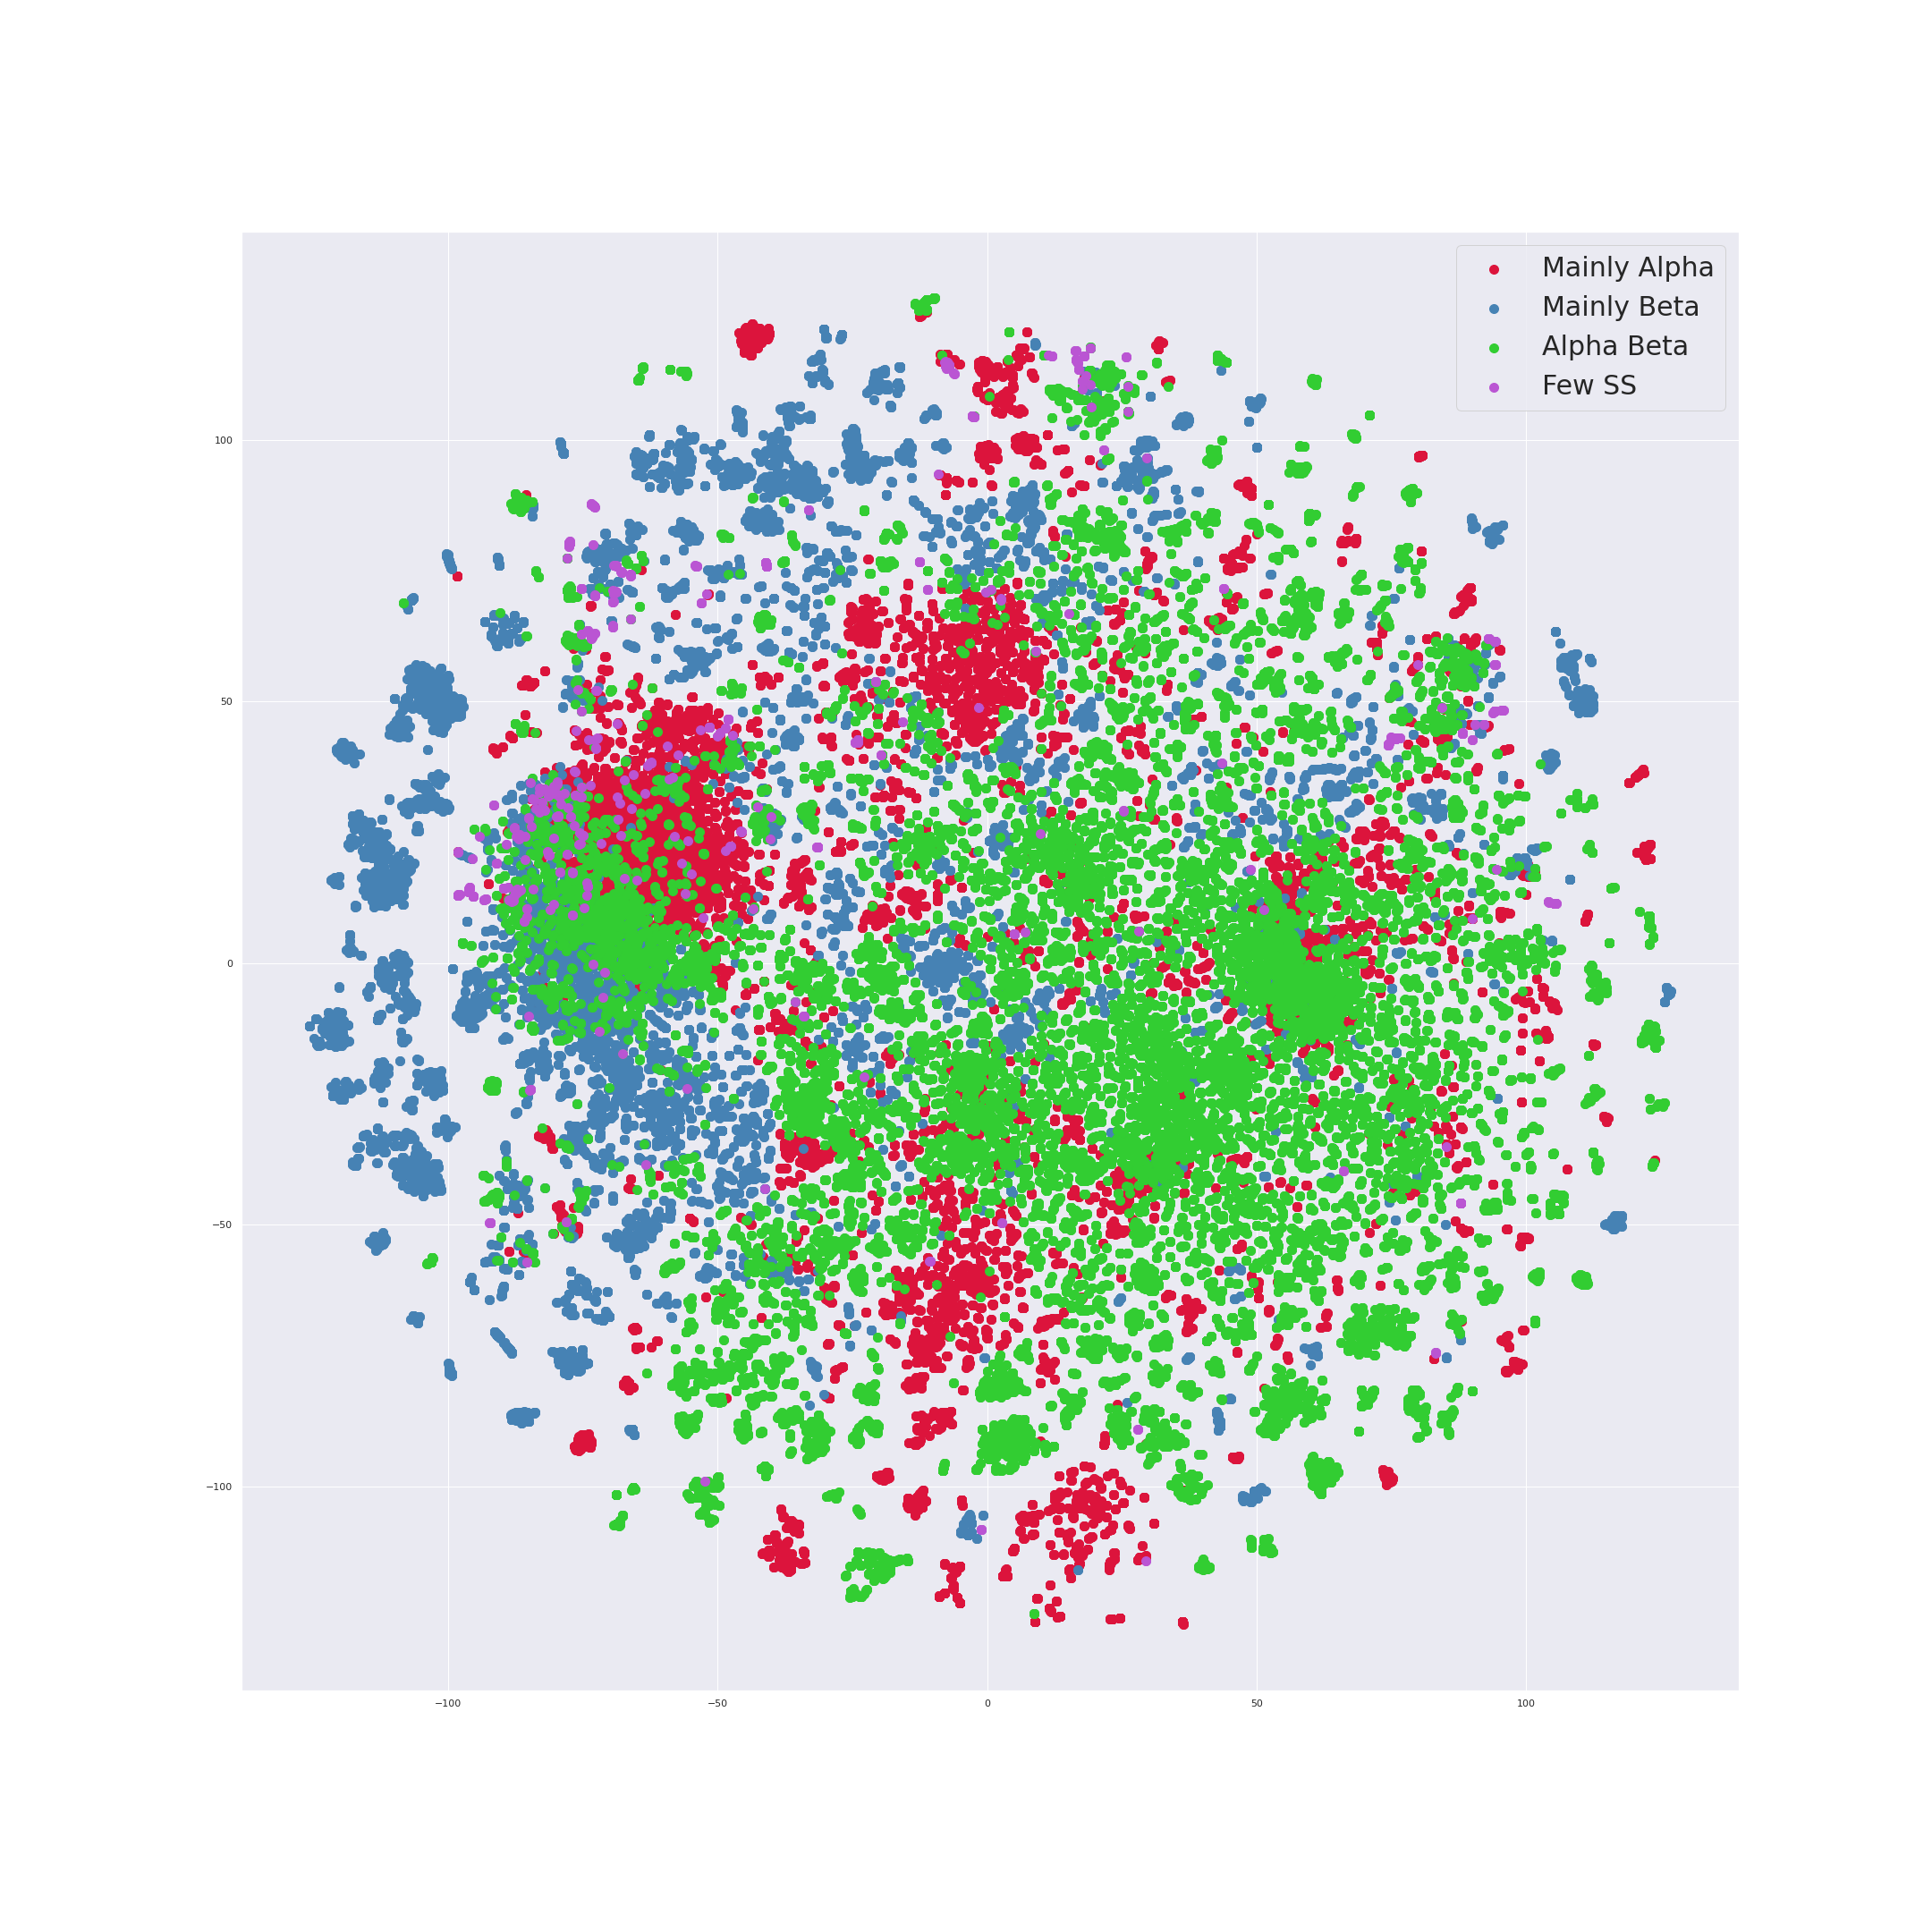

In [7]:
Image('orignal_embeddings.png')

In [79]:
xtsne = []
ytsne = []
for i in list(train.id2embedding.keys()):
  if train.id2label[i][0] <= 4:
    xtsne.append(model(torch.stack([train.id2embedding[i], train.id2embedding[i], train.id2embedding[i]], dim=1))[0].detach().cpu().numpy())
    ytsne.append(train.id2label[i][0])

In [81]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.array(xtsne).squeeze(1))

In [106]:
cdict = {1: 'crimson', 2: 'steelblue', 3: 'limegreen', 4: 'mediumorchid'}

fig, ax = plt.subplots()
for g in np.unique(np.array(ytsne)):
    ix = np.where(np.array(ytsne) == g)
    ax.scatter(X_embedded[:,0][ix], X_embedded[:,1][ix], c = cdict[g], label = g, s = 100)
ax.legend(["Mainly Alpha", "Mainly Beta", "Alpha Beta", "Few SS"], fontsize=30, title_fontsize=35,loc='best')
plt.savefig("orignal_model_embeddings.png")
plt.show()

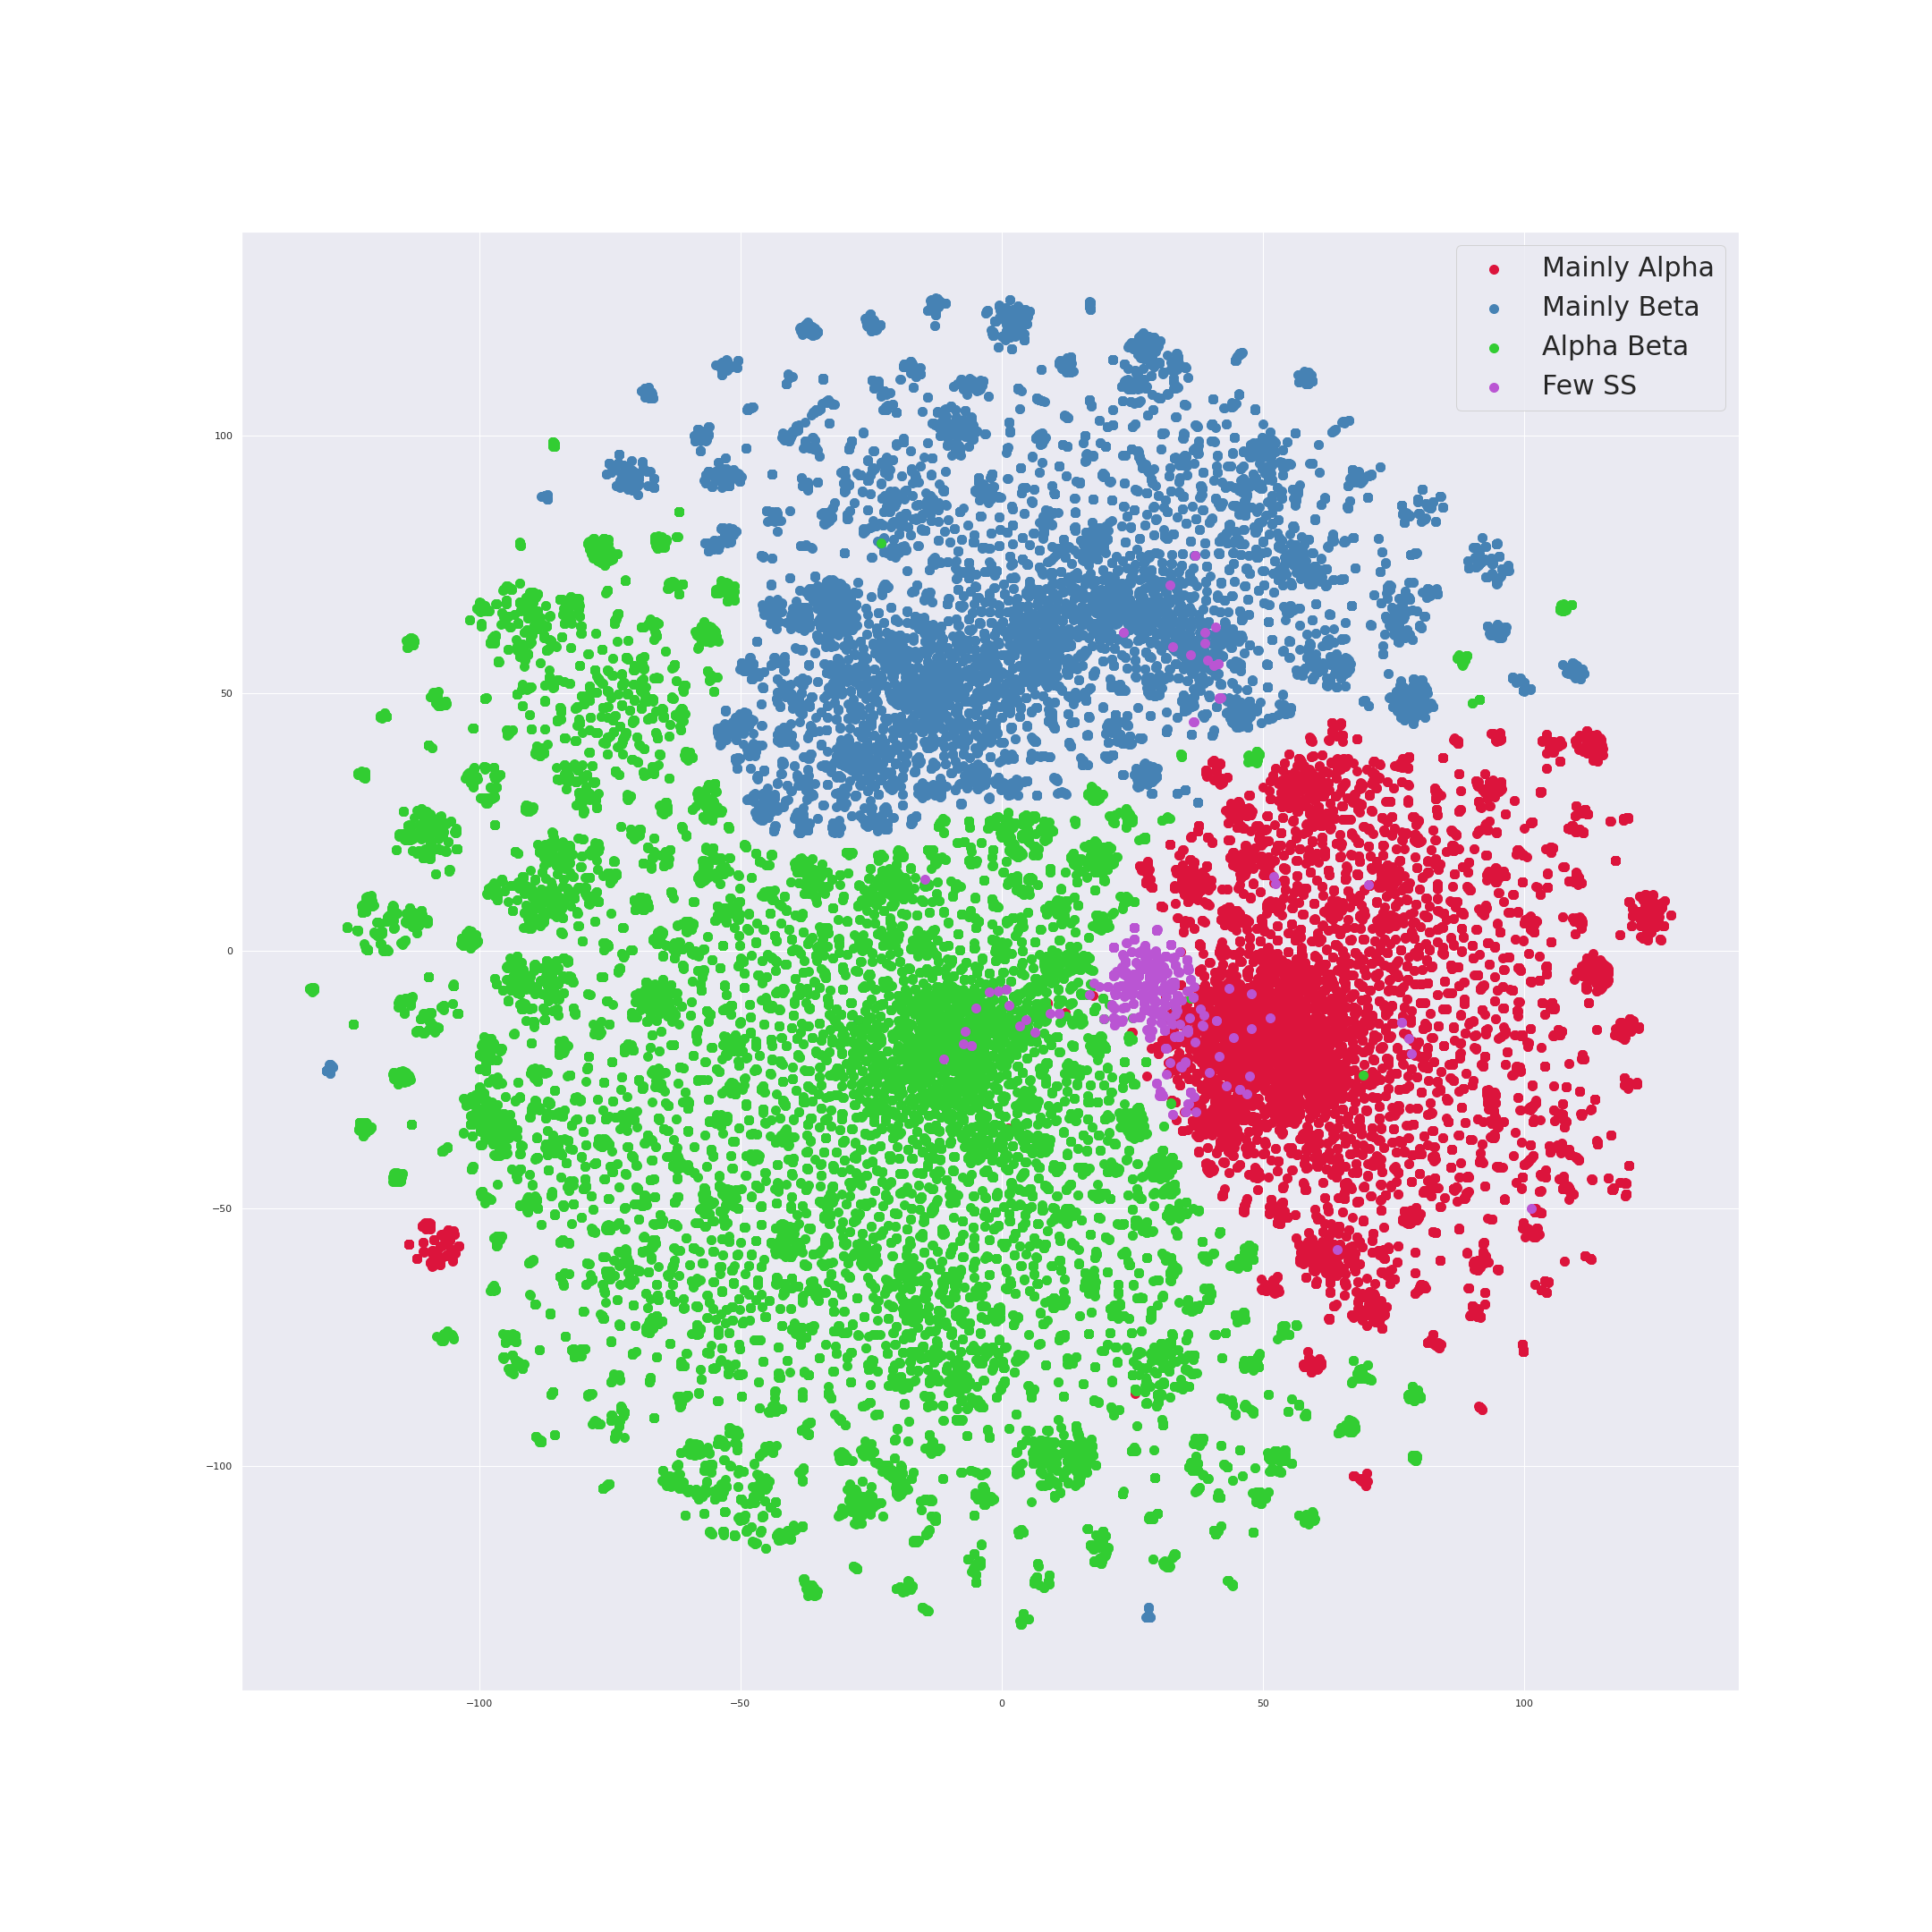

In [8]:
Image('orignal_model_embeddings.png')

# Triplet Loss
Checking how much improvement using batch hard sampling has over normal loss calculation. (This does not take into account the labels aswell)



In [115]:
# measure training time
start_overall = time.time()
# set random seeds
SEED = 42
seed_all(SEED)
# set up directory structure
root = Path.cwd()
data_dir = root / 'data' # create a directory for logging your experiments
log_dir = root / 'log' / 'your_log_directory'
embedding_p = data_dir / "ProtTucker" /"prott5_cath_S100.h5" # path to your pre-computed embeddings. IDs have to align with label IDs
print("Loading dataset from: {}".format(embedding_p))
# give your experiment a meaningful name here
experiment_name = "your_experiment"
experiment_dir = log_dir / experiment_name
if not experiment_dir.is_dir():
    print("Creating new log-directory: {}".format(experiment_dir))
    experiment_dir.mkdir(parents=True)
# Hyperparameters
learning_rate = 1e-3
batch_size = 256 # the number of actual samples per batch might be higher due to batch-hard sampling (see paper for more details)
num_epochs = 200  # will stop earlier if early stopping is triggered
n_classes = 4  # number of class-lvls; makes it easier to adjust for other problems
n_bad = 0 # counter for number of epochs that did not improve (counter for early stopping)
n_thresh = 20  # threshold for number of epochs that did not improve (threshold for early stopping)
batch_hard = True  # whether to activate batch_hard sampling (recommneded)
exclude_easy = False # whether to exclude trivial samples (did not improve performa)
margin = None # set this to a float to activate threshold-dependent loss functions (see TripletLoss)
# initialize plotting class (used to monitor loss etc during training)
pltr = plotter(experiment_dir)
# Prepare datasets
datasplitter = DataSplitter(embedding_p)
train_splits, val, val_lookup20 = datasplitter.get_predef_splits()
val20 = Eval(val_lookup20, val,  datasplitter, n_classes)
train = CustomDataset(train_splits, datasplitter, n_classes)
train.get_example()
train.get_example()
train.get_example()
train = dataloader(train, batch_size)
model = ProtTucker().to(device)
criterion = nn.TripletMarginLoss(margin=0.0, p=2)
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, amsgrad=True)
saver = Saver(experiment_dir)
saver.save_checkpoint(model, 0, optimizer)
baseline_acc, baseline_err = get_baseline(val20)
print('###### Training parameters ######')
print('Experiment name: {}'.format(experiment_name))
print('LR: {}, BS: {}, free Paras.: {}, n_epochs: {}'.format(
    learning_rate, batch_size, count_parameters(model), num_epochs))
print('#############################\n')
print('Start training now!')
monitor = init_monitor()
for epoch in range(num_epochs):  # for each epoch
    # =================== testing =====================
    start = time.time()
    acc, err = testing(model, val20)  # evaluate using the validation
    test_time = time.time() - start
    new_best = saver.check_performance(
        acc, model, epoch, optimizer)  # early stopping class
    if new_best is None:  # if the new accuracy was worse than a previous one
        n_bad += 1
        if n_bad >= n_thresh:  # if more than n_bad consecutive epochs were worse, break training
            break
    else:  # if the new accuracy is larger than the previous best one by epsilon, reset counter
        n_bad = 0
    # =================== training =====================
    # monitor epoch-wise performance
    epoch_monitor = init_monitor()
    start = time.time()
    for train_idx, (X, Y, _) in enumerate(train):  # for each batch in the training set
        X = X.to(device)
        Y = Y.to(device)
        anchor, pos, neg = model(X)
        loss = criterion(anchor, pos, neg)
        # =================== backward ====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_time = time.time() - start
        epoch_monitor['loss'].append(toCPU(loss))
        epoch_monitor['norm'].append(toCPU(torch.norm(torch.cat((anchor, pos, neg)), p='fro')))
       # monitor various metrics during training
    monitor['loss'].append(
        sum(epoch_monitor['loss']) / len(epoch_monitor['loss']))
    monitor['norm'].append(
        sum(epoch_monitor['norm']) / len(epoch_monitor['norm']))
    #monitor['pos'].append(sum(epoch_monitor['pos']) /
    #                      len(epoch_monitor['pos']))
    #monitor['neg'].append(sum(epoch_monitor['neg']) /
    #                      len(epoch_monitor['neg']))
    #monitor['min'].append(sum(epoch_monitor['min']) /
    #                      len(epoch_monitor['min']))
    #monitor['max'].append(sum(epoch_monitor['max']) /
    #                      len(epoch_monitor['max']))
    #monitor['mean'].append(
    #    sum(epoch_monitor['mean']) / len(epoch_monitor['mean']))
    train_time = time.time() - start
    # ===================log========================
    if epoch % 5 == 0 or epoch == num_epochs-1:  # draw plots only every fifth epoch
        pltr.plot_acc(acc, baseline_acc)
        #pltr.plot_distances(monitor['pos'], monitor['neg'])
        pltr.plot_loss(monitor['loss'], file_name='loss.pdf')
        pltr.plot_loss(monitor['norm'], file_name='norm.pdf')
        pltr.plot_minMaxMean(monitor)
    # Always print training progress to console
    print(('epoch [{}/{}], train loss: {:.3f}, train-time: {:.1f}[s], test-time: {:.1f}[s], ' +
          'ACC-C: {:.2f}, ACC-A: {:.2f}, ACC-T: {:.2f}, ACC-H: {:.2f} ## Avg. Acc: {:.2f}').format(
        epoch + 1, num_epochs,
        monitor['loss'][-1],
        train_time, test_time,
        acc[0][-1], acc[1][-1], acc[2][-1], acc[3][-1],
        (acc[0][-1] + acc[1][-1] + acc[2][-1] + acc[3][-1])/4
    ))
end_overall = time.time()
print(end_overall-start_overall)
print("Total training time: {:.1f}[m]".format(
    (end_overall-start_overall)/60))


[ Using Seed :  42  ]
Loading dataset from: /content/drive/MyDrive/EAT/EAT/data/ProtTucker/prott5_cath_S100.h5
Example: 107lA00
Loaded embeddings for n_proteins: 122727
Finished parsing n_domains: 500253
Total length of id2label: 122727
Example CATH ID: 2anlA01
-- Loaded 200 proteins from /content/drive/MyDrive/EAT/EAT/data/ProtTucker/val200.fasta
Example CATH ID: 9wgaA04
-- Loaded 66052 proteins from /content/drive/MyDrive/EAT/EAT/data/ProtTucker/train66k.fasta
Example CATH ID: 9wgaA04
-- Loaded 66052 proteins from /content/drive/MyDrive/EAT/EAT/data/ProtTucker/train66k.fasta
##########
Finished splitting data!
Train set size: 66052
Val set size: 200
ValLookup20 size: 66052
##########
Finished parsing n_domains: 500253
Total length of id2label: 66252
Finished parsing n_domains: 500253
Total length of id2label: 66052
#### Example ####
Anc (4qkrA00) label: [2, 80, 10, 50]
Pos (4mzgB00) label: [2, 80, 10, 70]
Neg (1yu0A02) label: [2, 80, 20, 10]
#### Example ####
#### Example ####
Anc (4

In [118]:
xtsne = []
ytsne = []
train = CustomDataset(train_splits, datasplitter, n_classes)
for i in list(train.id2embedding.keys()):
  if train.id2label[i][0] <= 4:
    xtsne.append(model(torch.stack([train.id2embedding[i], train.id2embedding[i], train.id2embedding[i]], dim=1))[0].detach().cpu().numpy())
    ytsne.append(train.id2label[i][0])

Finished parsing n_domains: 500253
Total length of id2label: 66052


In [119]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.array(xtsne).squeeze(1))

In [120]:
cdict = {1: 'crimson', 2: 'steelblue', 3: 'limegreen', 4: 'mediumorchid'}

fig, ax = plt.subplots()
for g in np.unique(np.array(ytsne)):
    ix = np.where(np.array(ytsne) == g)
    ax.scatter(X_embedded[:,0][ix], X_embedded[:,1][ix], c = cdict[g], label = g, s = 100)
ax.legend(["Mainly Alpha", "Mainly Beta", "Alpha Beta", "Few SS"], fontsize=30, title_fontsize=35,loc='best')
plt.savefig("triplet_loss_embeddings.png")
plt.show()

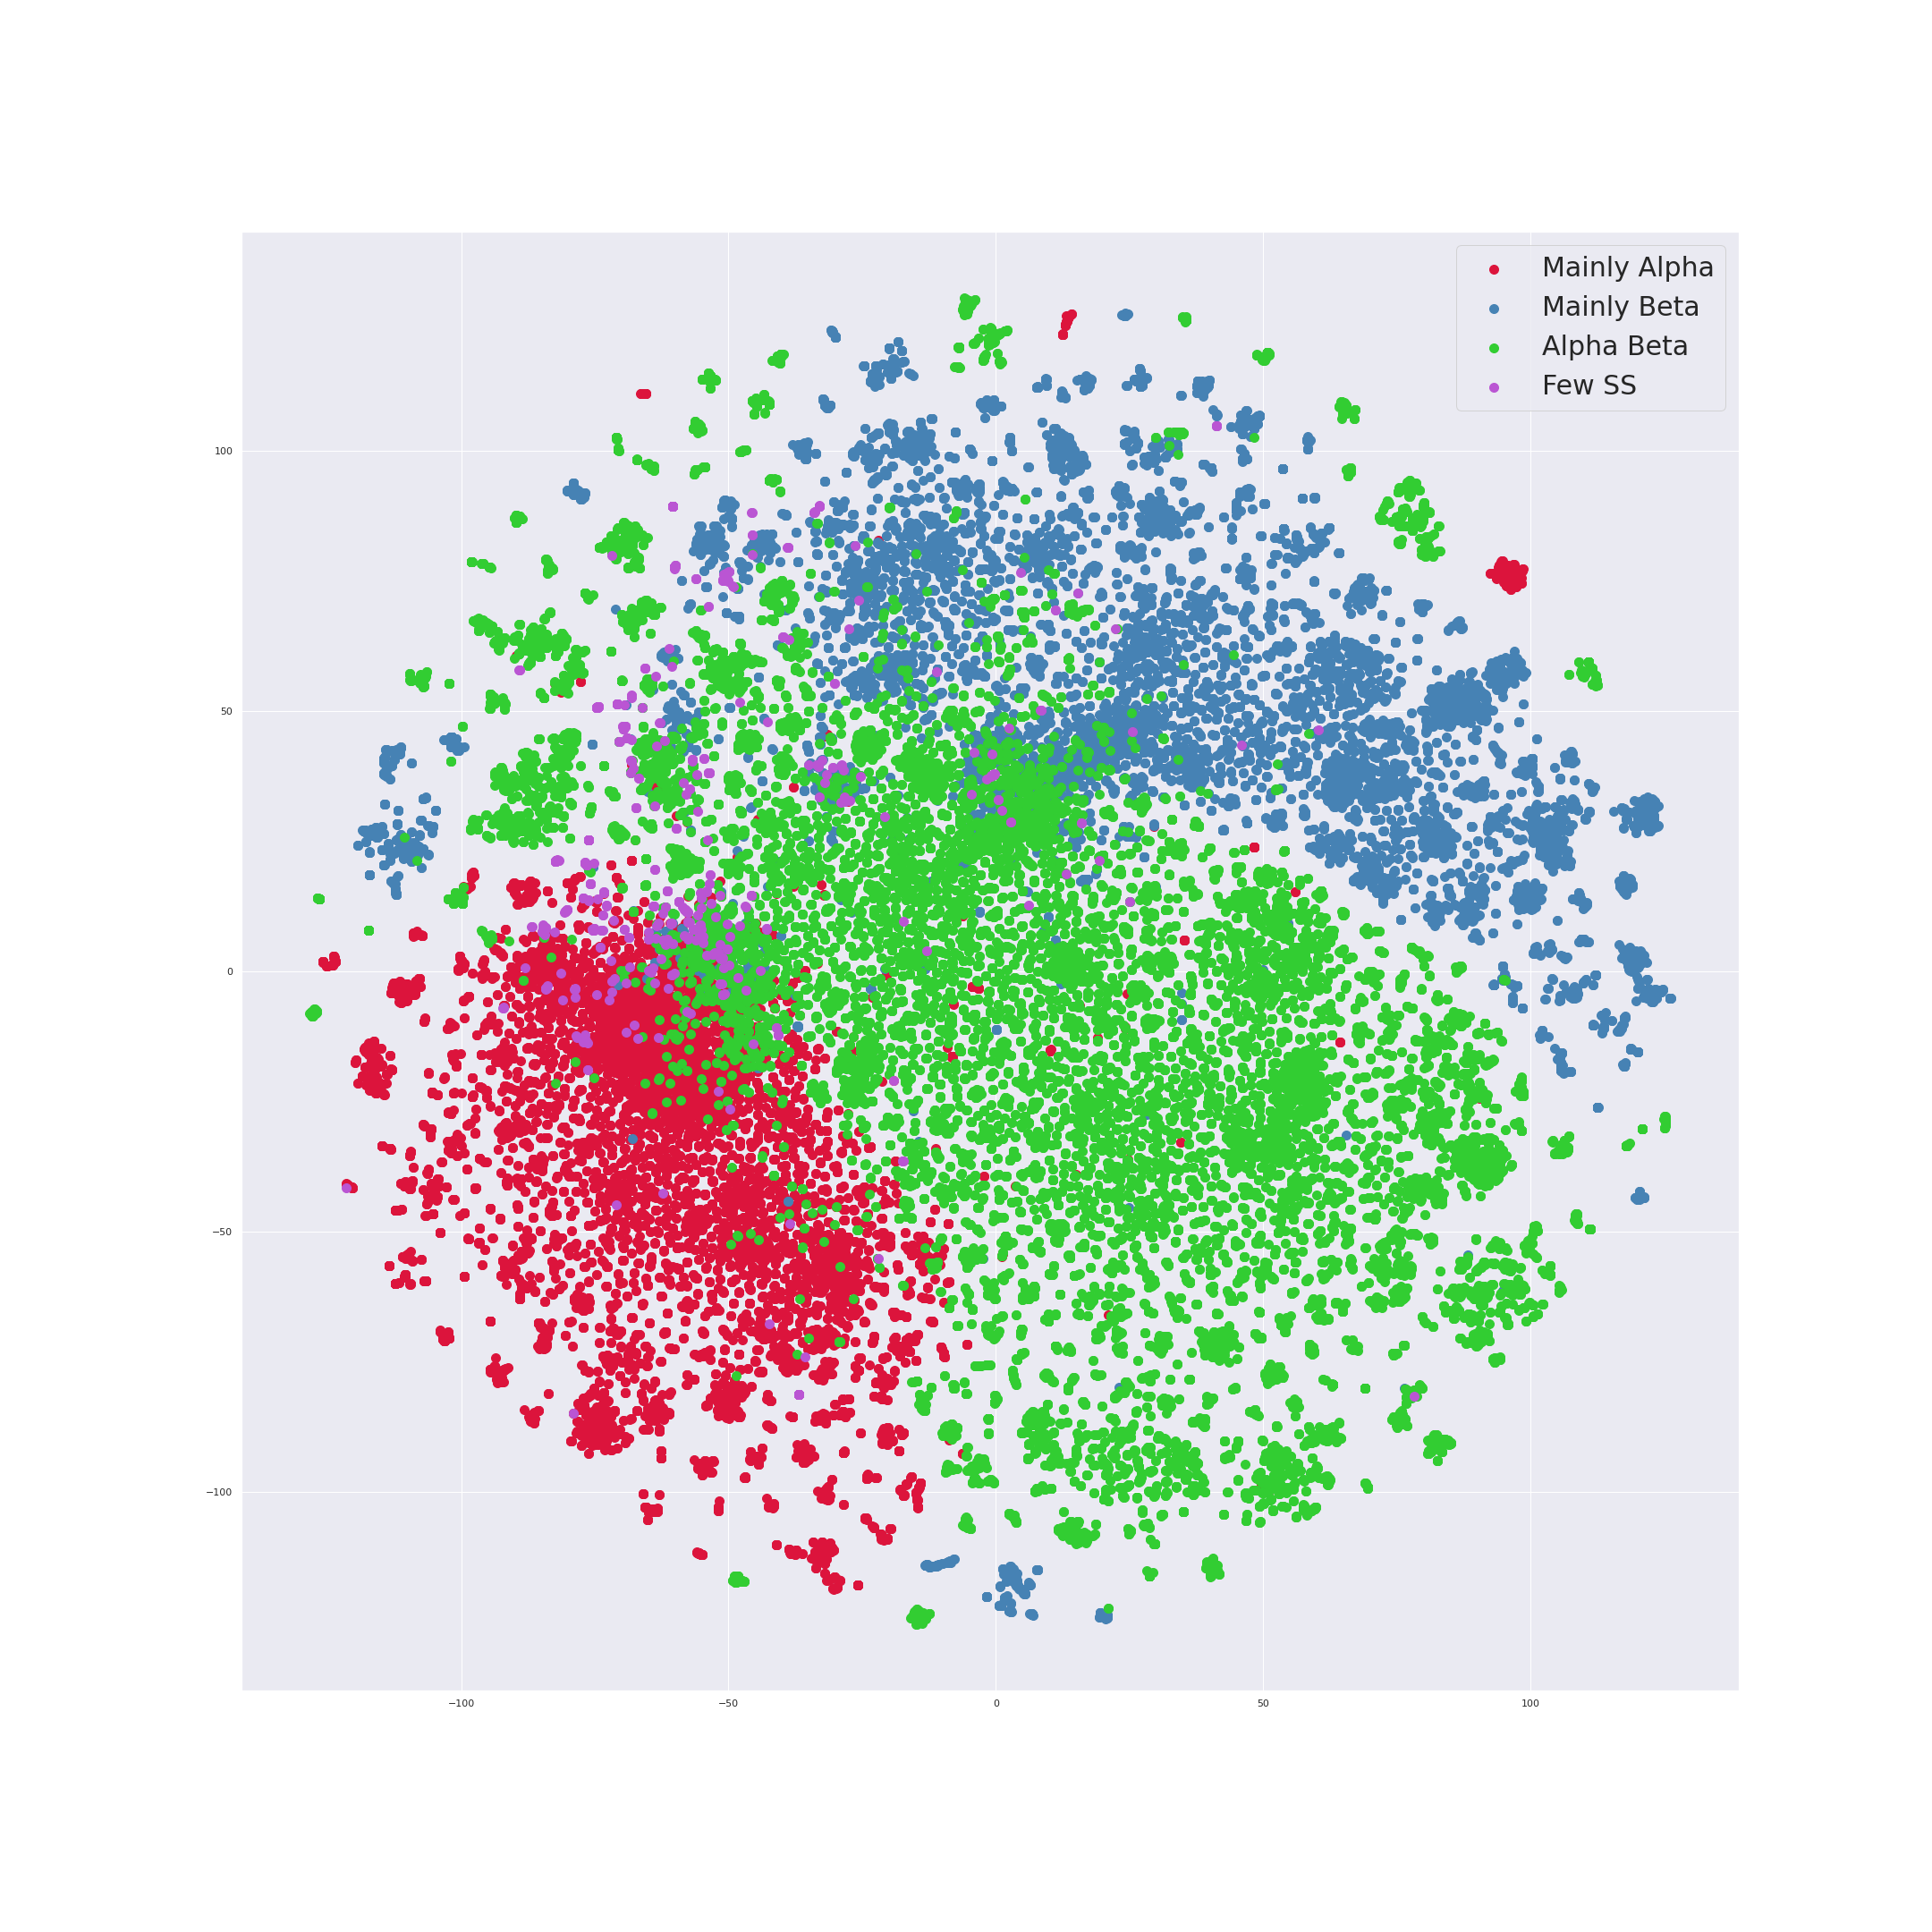

In [9]:
Image('triplet_loss_embeddings.png')

### significantly worse